## CSS Project Part 2
Arathy Pillai, Alexander Guth, Hammad Akthar, Hiba Saleel and Julian Jetz

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from pandas.plotting import scatter_matrix
from string import punctuation
from scipy import stats
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score, mean_absolute_error
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns
import statsmodels.api as sm

In [2]:
plot_size = plt.rcParams["figure.figsize"]  
plot_size[0] = 15  
plot_size[1] = 8  
plt.rcParams["figure.figsize"] = plot_size  

### Load data and determine na values
repost and Text are determined as na values, because they ... **[TODO]**

In [3]:
na_values = ['nan', 'N/A', 'NaN', 'NaT', '0', '', 'Text', 'repost', 'r e p o s t -', 'Repost']
ira_data = pd.read_csv('../Data/data_IRA_Ads.csv', sep=";", parse_dates=['AD_CREATION_DATE', 'AD_END_DATE'], 
                       dayfirst=False, index_col='AD_ID', na_values=na_values)
#ira_data = ira_data[(ira_data['AD_IMPRESSIONS']> 0) & ira_data['AD_CLICKS'] > 0]

### Click per View Ratio
#Clicks / #Impressions

In [4]:
ira_data.insert(5, 'AD_CLICKS_PER_VIEW', ira_data['AD_CLICKS']/ira_data['AD_IMPRESSIONS'])

### Date operations
Get epoch time (ms since 01.01.1970)

In [5]:
epoch = datetime.datetime.utcfromtimestamp(0)

def unix_time_millis(dt):
    return (dt - epoch).total_seconds() * 1000.0

def time_to_ms(dt):
    return dt.hour * 3600 + dt.minute * 60 + dt.second + dt.microsecond / 1000 / 1000

In [6]:
ira_data['AD_CREATION_WEEKDAY'] = ira_data['AD_CREATION_DATE'].dt.dayofweek
ira_data['AD_CREATION_YEAR'] = ira_data['AD_CREATION_DATE'].dt.year
ira_data['AD_CREATION_MONTH'] = ira_data['AD_CREATION_DATE'].dt.month
ira_data['AD_CREATION_DAY'] = ira_data['AD_CREATION_DATE'].dt.day
ira_data['AD_CREATION_TIME'] = ira_data['AD_CREATION_DATE'].apply(lambda x: time_to_ms(x))
ira_data['AD_CREATION_EPOCH_TIME'] = ira_data['AD_CREATION_DATE'].apply(lambda x: unix_time_millis(x))

### Convert ruble
Removes "RUB" from the cell AD_SPEND

In [7]:
ira_data['AD_SPEND']=ira_data['AD_SPEND'].str.replace(' RUB','').astype('float')

### Drop all subsets, where AD_TEXT is na

In [8]:
ira_data=ira_data.dropna(subset=['AD_TEXT']);
ira_data['AD_TEXT'].count()

3436

### Cleaning up Targeting Data

In [9]:
def remove_punctuation_at_the_end(x):
    #remove "," and "." and ":" from the end of x
    x = x.rstrip(',')
    x = x.rstrip('.')
    x = x.rstrip(':')
    #replace ";" and ",." with "," in x
    x = x.replace(';', ',')
    x = x.replace(',.', ',')
    return x

In [10]:
#replace abbreviations with their long form in AD_TARGETING_EXCLUDED_CONNECTIONS
ira_data['AD_TARGETING_EXCLUDED_CONNECTIONS']=ira_data['AD_TARGETING_EXCLUDED_CONNECTIONS'].str.replace('Exclude people who like BM','Exclude people who like Black Matters')

#replace ")or" (missing space) with ") or" and ");" with ")," in AD_TARGETING_LANGUAGE due to having a different formats used
ira_data['AD_TARGETING_LANGUAGE'] = ira_data['AD_TARGETING_LANGUAGE'].str.replace('\)or', ') or')
ira_data['AD_TARGETING_LANGUAGE'] = ira_data['AD_TARGETING_LANGUAGE'].str.replace('\);', '),')

#??Remove lines without AD_TARGETING_INTERESTS and execute remove_punctuation_at_the_end on each string in AD_TARGETING_INTERESTS
ira_data['AD_TARGETING_INTERESTS'] = ira_data['AD_TARGETING_INTERESTS'].dropna().apply(lambda x: remove_punctuation_at_the_end(str(x)))
ira_data['AD_TARGETING_PEOPLE_WHO_MATCH'] = ira_data['AD_TARGETING_PEOPLE_WHO_MATCH'].dropna().apply(lambda x: remove_punctuation_at_the_end(str(x)))
ira_data['AD_TARGETING_EXCLUDE'] = ira_data['AD_TARGETING_EXCLUDE'].dropna().apply(lambda x: remove_punctuation_at_the_end(str(x)))

### Remove hyperlinks

In [11]:
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'https?:\/\/.*[\r\n]*', '')
ira_data['AD_TEXT']=ira_data['AD_TEXT'].str.replace(r'http?:\/\/.*[\r\n]*', '')

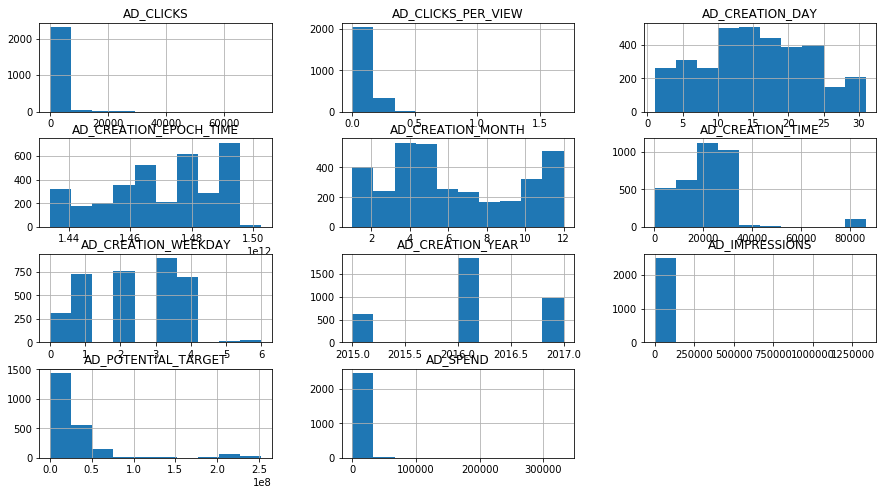

In [12]:
ira_data.hist();

### Flag all duplicate ad texts

In [13]:
ira_data['Duplicate'] = ira_data['AD_TEXT'].duplicated(keep=False)

### Total Duplicates

In [14]:
ira_data['AD_TEXT'].count()

3436

In [15]:
ira_data['Duplicate'].value_counts()

False    1998
True     1438
Name: Duplicate, dtype: int64

### Unique Duplicate Pairs

In [16]:
ira_data['AD_TEXT'][ira_data['Duplicate'] == True].nunique()

361

### Occurence of Duplicate Pairs

In [17]:
ira_data['AD_TEXT'][ira_data['Duplicate'] == True].value_counts().values

array([53, 23, 18, 16, 14, 14, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10,
       10, 10,  9,  9,  9,  9,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2

In [18]:
ira_data[(ira_data['Duplicate'] == True) & ira_data['AD_TEXT'].str.match('We speak for all fellow members of LGBT community across the nation.')][['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CREATION_DATE', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_DAY','AD_CREATION_TIME','AD_TEXT', 'AD_SPEND', 'AD_POTENTIAL_TARGET']].head(20)

,AD_CLICKS,AD_IMPRESSIONS,AD_CREATION_DATE,AD_CREATION_WEEKDAY,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_DAY,AD_CREATION_TIME,AD_TEXT,AD_SPEND,AD_POTENTIAL_TARGET
AD_ID,,,,,,,,,,,
580,103.0,122.0,2015-06-16 03:36:10,1,2015,6,16,12970.0,We speak for all fellow members of LGBT commun...,129.66,35000000.0
581,36.0,1438.0,2015-06-17 03:15:18,2,2015,6,17,11718.0,We speak for all fellow members of LGBT commun...,1362.57,144000000.0
582,1724.0,18891.0,2015-06-18 00:58:48,3,2015,6,18,3528.0,We speak for all fellow members of LGBT commun...,10085.77,35000000.0
583,186.0,4265.0,2015-06-22 08:19:07,0,2015,6,22,29947.0,We speak for all fellow members of LGBT commun...,1393.55,139000000.0
584,3206.0,31618.0,2015-06-23 05:06:57,1,2015,6,23,18417.0,We speak for all fellow members of LGBT commun...,16630.20,143000000.0
585,1252.0,11857.0,2015-07-01 02:55:07,2,2015,7,1,10507.0,We speak for all fellow members of LGBT commun...,5538.24,165000000.0
586,59.0,1811.0,2015-07-07 01:51:07,1,2015,7,7,6667.0,We speak for all fellow members of LGBT commun...,757.65,166000000.0
587,542.0,15175.0,2015-07-09 01:50:28,3,2015,7,9,6628.0,We speak for all fellow members of LGBT commun...,6201.70,35000000.0
588,21449.0,175460.0,2015-07-14 00:01:38,1,2015,7,14,98.0,We speak for all fellow members of LGBT commun...,93754.38,41000000.0


### Dealing with Missing Values

Multiple Imputation using MICE (Multiple Imputation by Chained Equations)

In [19]:
# https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-2-222154b4b58e
#from fancyimpute import MICE
#ira_cols=list(ira_data)
#ira_data = pd.DataFrame(MICE(verbose=False).complete(ira_data))
#ira_data.columns = ira_cols

### Common Statistics
**[TODO]** Mean, median etc. for success --> Chart(?) ==> Alex

### Correlations

In [20]:
colormap = plt.cm.RdBu

In [21]:
corrDf = ira_data[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']].dropna()

In [22]:
std_dev = 3
corrDf = corrDf[(np.abs(stats.zscore(corrDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_SPEND']])) < float(std_dev)).all(axis=1)]

In [23]:
corrDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1554 entries, 1 to 3517
Data columns (total 10 columns):
AD_CLICKS                 1554 non-null float64
AD_IMPRESSIONS            1554 non-null float64
AD_CLICKS_PER_VIEW        1554 non-null float64
AD_SPEND                  1554 non-null float64
AD_POTENTIAL_TARGET       1554 non-null float64
AD_CREATION_WEEKDAY       1554 non-null int64
AD_CREATION_EPOCH_TIME    1554 non-null float64
AD_CREATION_YEAR          1554 non-null int64
AD_CREATION_MONTH         1554 non-null int64
AD_CREATION_TIME          1554 non-null float64
dtypes: float64(7), int64(3)
memory usage: 133.5 KB


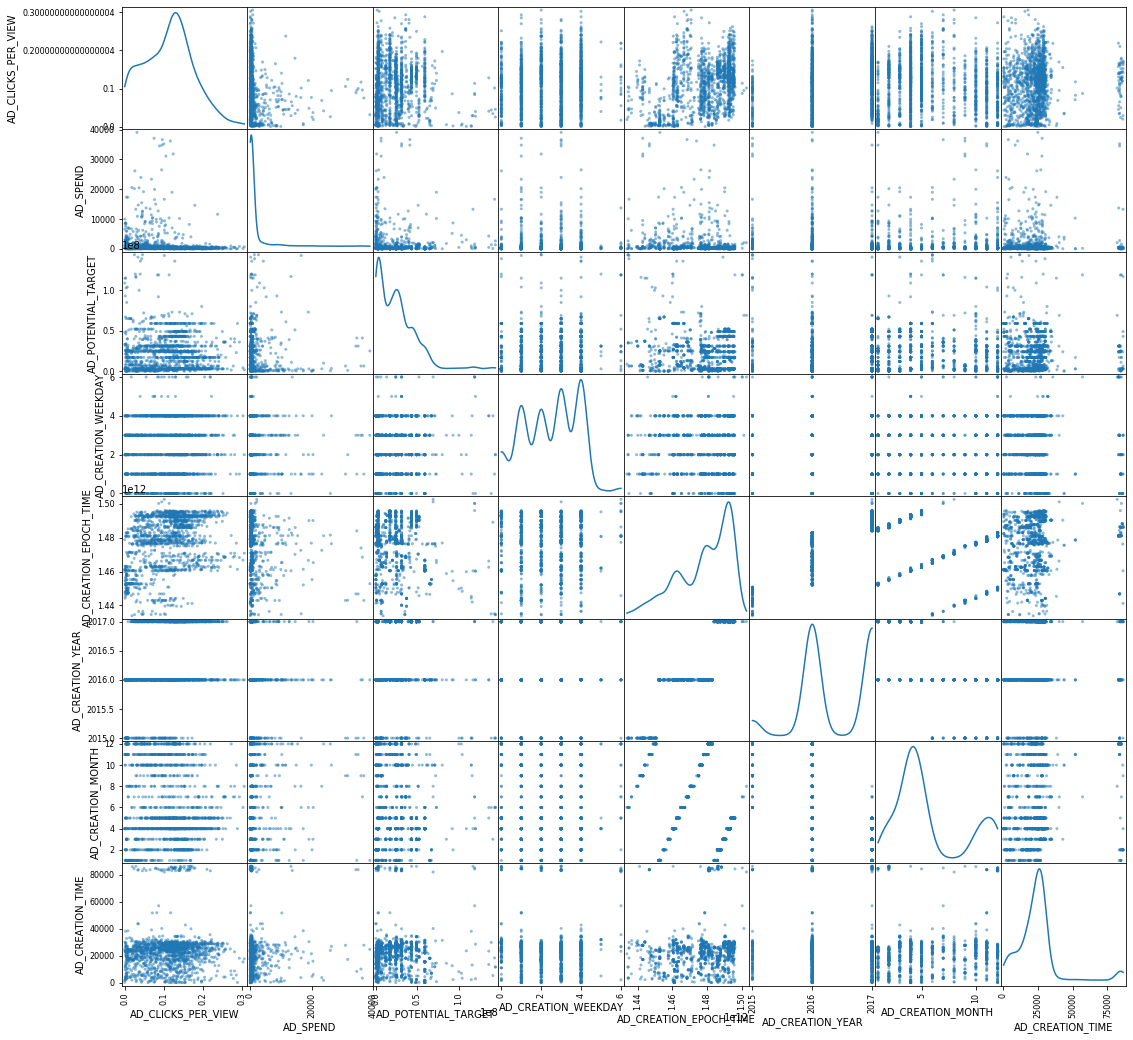

In [24]:
scatter_matrix(corrDf[['AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']], diagonal='kde', figsize=(18, 18))
plt.savefig(r"../Images/scatterALL.png")

In [25]:
corr = corrDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']].corr()
corr

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_SPEND,AD_POTENTIAL_TARGET,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_TIME
AD_CLICKS,1.000000,0.771097,0.287229,0.273346,0.091289,0.262391,0.242846,-0.071775,0.096041
AD_IMPRESSIONS,0.771097,1.000000,-0.055322,0.551563,0.056605,0.092323,0.084237,-0.020477,0.035253
AD_CLICKS_PER_VIEW,0.287229,-0.055322,1.000000,-0.186515,-0.012636,0.354221,0.322339,-0.095626,0.080137
AD_SPEND,0.273346,0.551563,-0.186515,1.000000,-0.047770,-0.184215,-0.182771,0.078756,-0.016608
AD_POTENTIAL_TARGET,0.091289,0.056605,-0.012636,-0.047770,1.000000,-0.161395,-0.090045,-0.079590,-0.041516
AD_CREATION_EPOCH_TIME,0.262391,0.092323,0.354221,-0.184215,-0.161395,1.000000,0.888941,-0.208785,0.136586
AD_CREATION_YEAR,0.242846,0.084237,0.322339,-0.182771,-0.090045,0.888941,1.000000,-0.632334,0.051611
AD_CREATION_MONTH,-0.071775,-0.020477,-0.095626,0.078756,-0.079590,-0.208785,-0.632334,1.000000,0.121738
AD_CREATION_TIME,0.096041,0.035253,0.080137,-0.016608,-0.041516,0.136586,0.051611,0.121738,1.000000


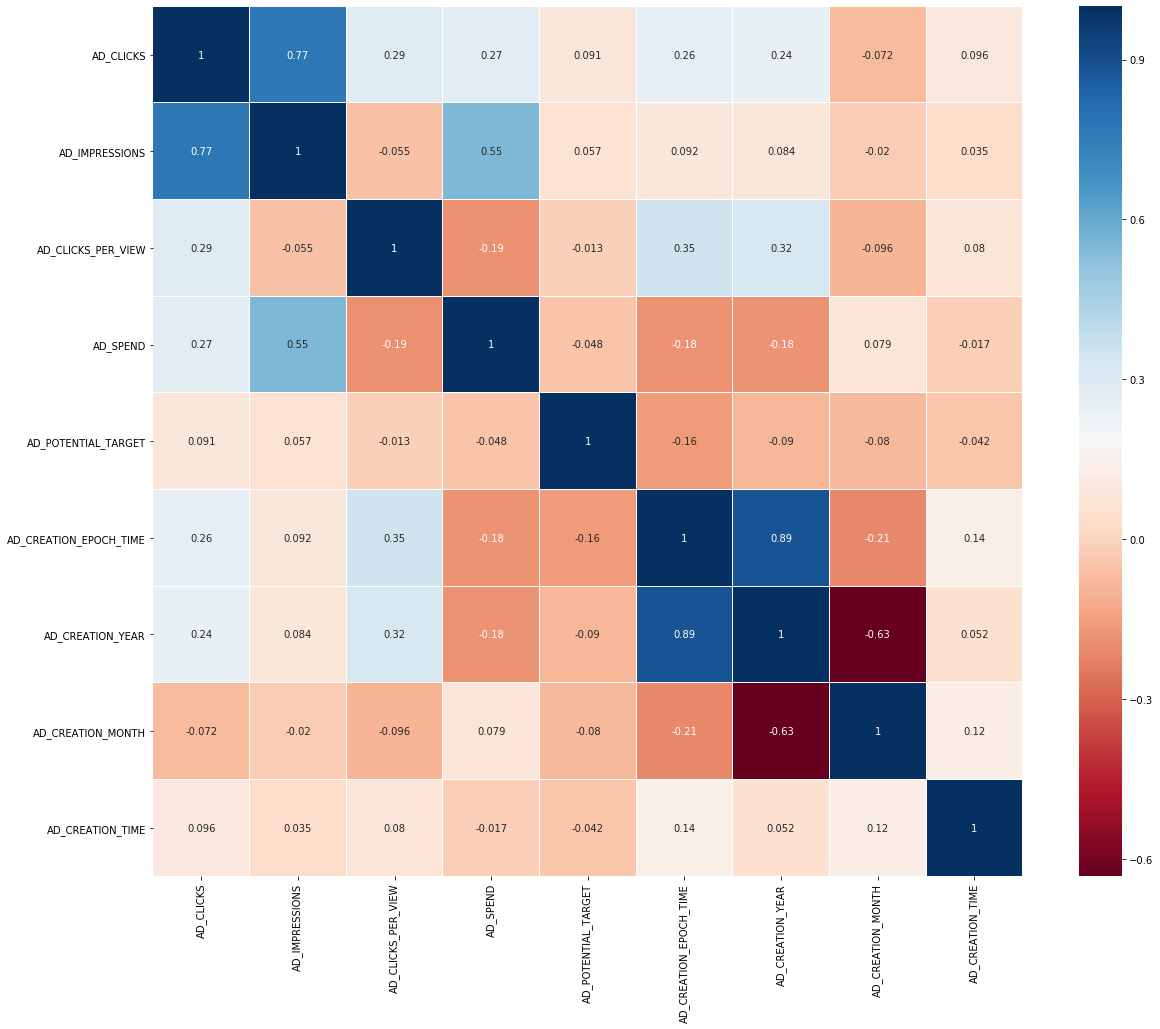

In [26]:
ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(corr,ax=ax,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);
plt.savefig(r"../Images/corrALL.png")

In [27]:
corrDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_CREATION_WEEKDAY
AD_CLICKS,1.000000,0.889771,0.498793,0.064635
AD_IMPRESSIONS,0.889771,1.000000,0.150179,0.042541
AD_CLICKS_PER_VIEW,0.498793,0.150179,1.000000,0.076336
AD_CREATION_WEEKDAY,0.064635,0.042541,0.076336,1.000000


#### Correlation: Unique Dataset

In [28]:
corrUniqueDf = ira_data[ira_data['Duplicate']==False][[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']].dropna()

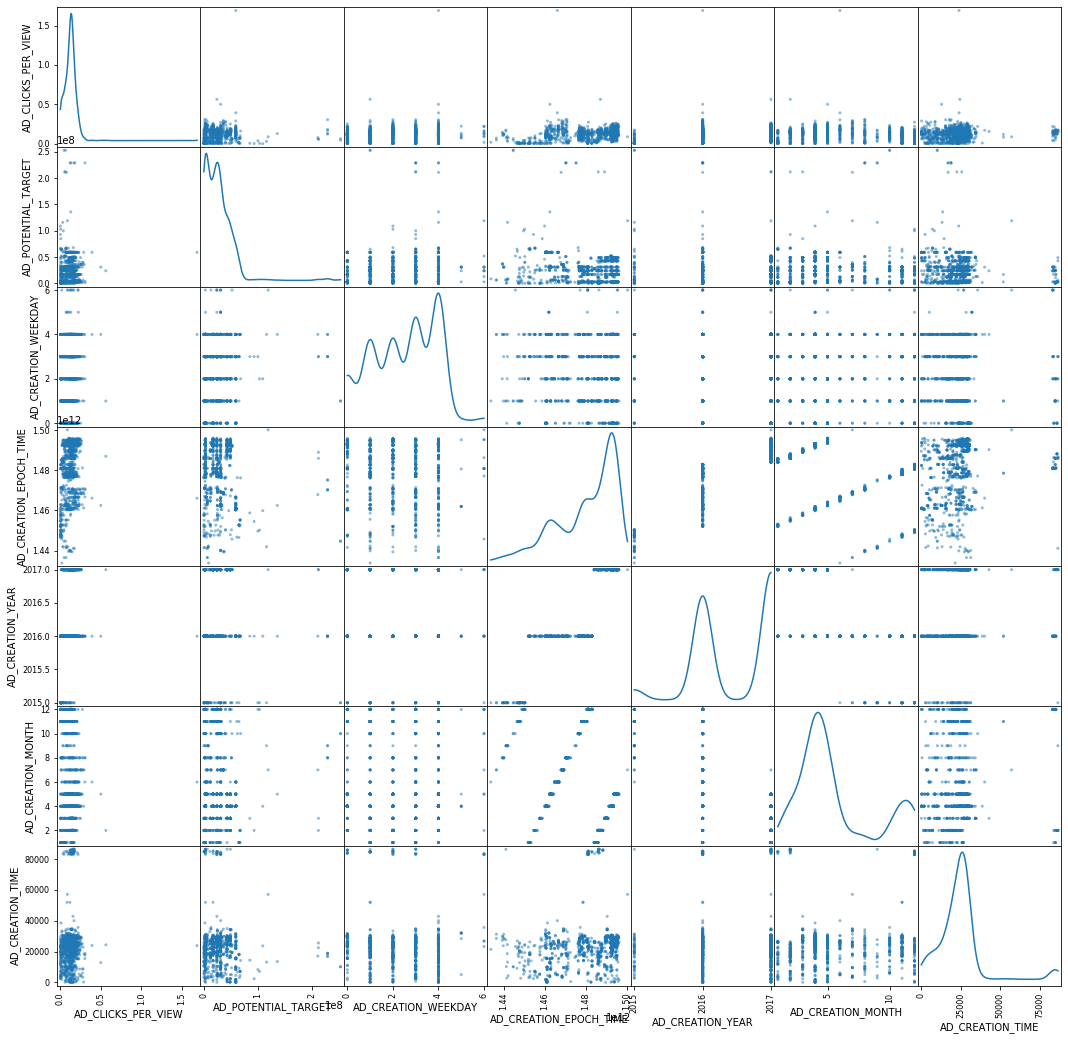

In [29]:
scatter_matrix(corrUniqueDf[['AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']], diagonal='kde', figsize=(18, 18))
plt.savefig(r"../Images/scatterUnique.png")

In [30]:
uCorr = corrUniqueDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']].corr()
uCorr

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_SPEND,AD_POTENTIAL_TARGET,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_TIME
AD_CLICKS,1.000000,0.883314,0.075732,0.516598,0.082800,0.178839,0.166382,-0.060130,0.048912
AD_IMPRESSIONS,0.883314,1.000000,-0.073856,0.720094,0.068237,0.041758,0.041729,-0.018529,0.007835
AD_CLICKS_PER_VIEW,0.075732,-0.073856,1.000000,-0.126283,0.018458,0.224331,0.215502,-0.098365,0.075590
AD_SPEND,0.516598,0.720094,-0.126283,1.000000,0.074783,-0.089475,-0.086542,0.038309,-0.037302
AD_POTENTIAL_TARGET,0.082800,0.068237,0.018458,0.074783,1.000000,-0.215345,-0.148597,-0.031076,-0.115874
AD_CREATION_EPOCH_TIME,0.178839,0.041758,0.224331,-0.089475,-0.215345,1.000000,0.890989,-0.272623,0.177527
AD_CREATION_YEAR,0.166382,0.041729,0.215502,-0.086542,-0.148597,0.890989,1.000000,-0.678409,0.080680
AD_CREATION_MONTH,-0.060130,-0.018529,-0.098365,0.038309,-0.031076,-0.272623,-0.678409,1.000000,0.117084
AD_CREATION_TIME,0.048912,0.007835,0.075590,-0.037302,-0.115874,0.177527,0.080680,0.117084,1.000000


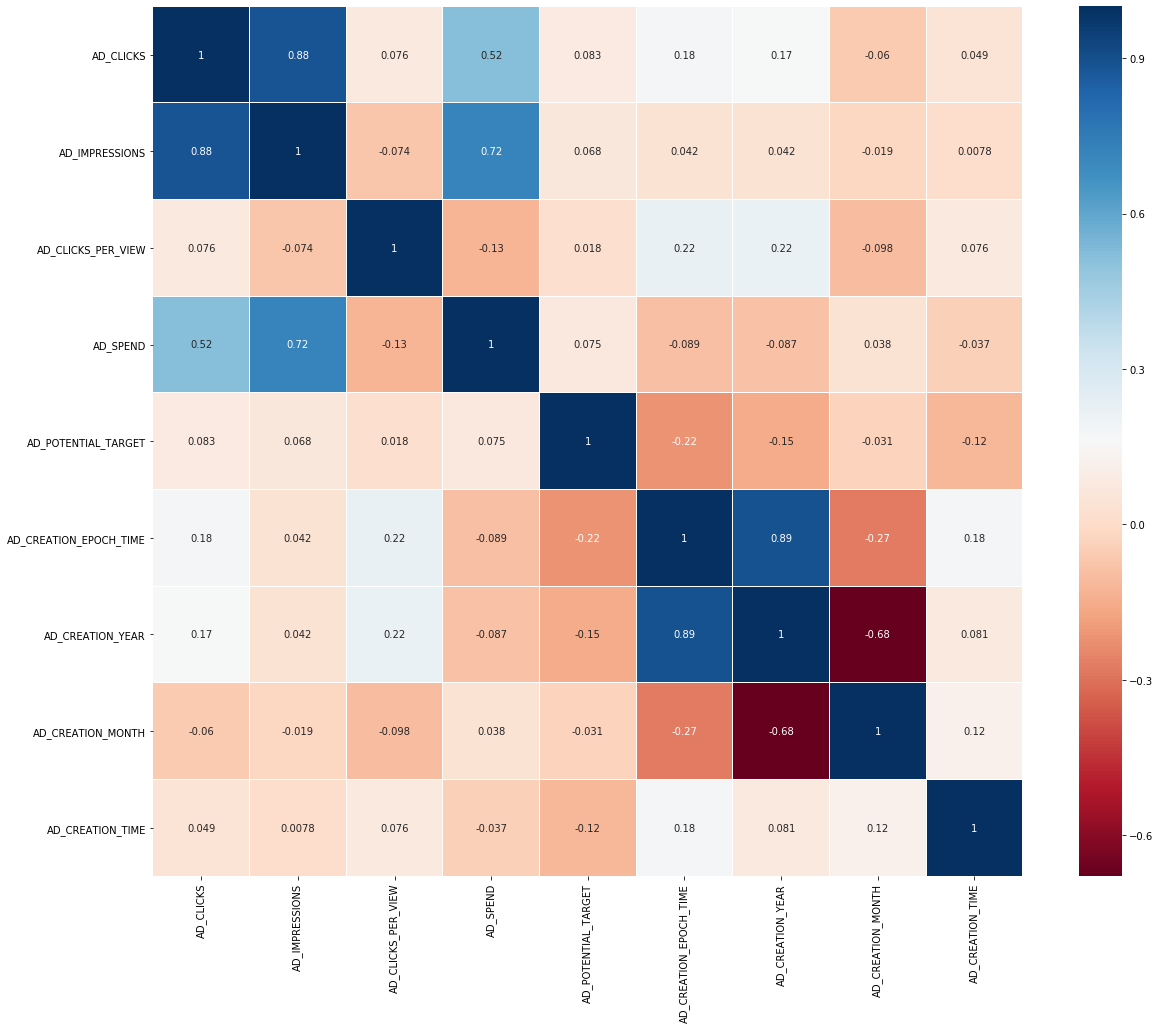

In [31]:
ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(uCorr, ax=ax,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);
plt.savefig(r"../Images/corrUnique.png")

In [32]:
corrUniqueDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_CREATION_WEEKDAY
AD_CLICKS,1.000000,0.886410,0.421503,0.042784
AD_IMPRESSIONS,0.886410,1.000000,0.072149,0.012415
AD_CLICKS_PER_VIEW,0.421503,0.072149,1.000000,0.075176
AD_CREATION_WEEKDAY,0.042784,0.012415,0.075176,1.000000


#### Correlation: Duplicate Dataset

In [33]:
corrDuplicateDf = ira_data[ira_data['Duplicate']==True][[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']].dropna()

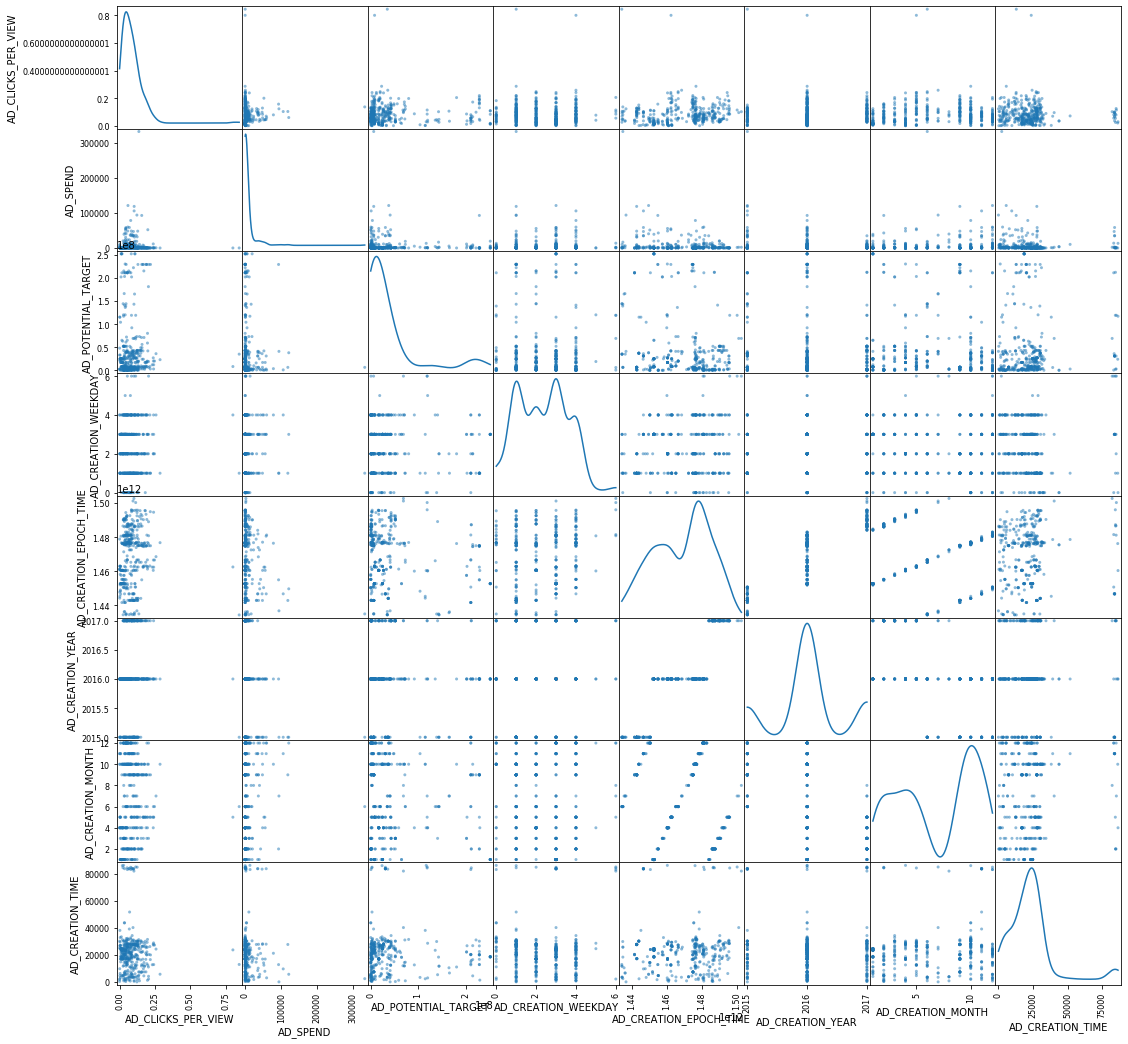

In [34]:
scatter_matrix(corrDuplicateDf[['AD_CLICKS_PER_VIEW', 'AD_SPEND','AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']], diagonal='kde', figsize=(18, 18))
plt.savefig(r"../Images/scatterDuplicate.png")

In [35]:
dCorr = corrDuplicateDf[[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']].corr()
dCorr

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_SPEND,AD_POTENTIAL_TARGET,AD_CREATION_EPOCH_TIME,AD_CREATION_YEAR,AD_CREATION_MONTH,AD_CREATION_TIME
AD_CLICKS,1.000000,0.911264,0.057086,0.834786,-0.083124,-0.025844,-0.073591,0.100410,-0.013914
AD_IMPRESSIONS,0.911264,1.000000,-0.041435,0.666336,-0.097229,0.004122,-0.061432,0.129470,-0.013166
AD_CLICKS_PER_VIEW,0.057086,-0.041435,1.000000,0.016955,0.013216,0.098913,0.046082,0.069331,-0.040721
AD_SPEND,0.834786,0.666336,0.016955,1.000000,-0.051941,-0.183734,-0.200342,0.080554,-0.060351
AD_POTENTIAL_TARGET,-0.083124,-0.097229,0.013216,-0.051941,1.000000,-0.137627,-0.074803,-0.087708,0.040933
AD_CREATION_EPOCH_TIME,-0.025844,0.004122,0.098913,-0.183734,-0.137627,1.000000,0.853441,0.017525,0.025039
AD_CREATION_YEAR,-0.073591,-0.061432,0.046082,-0.200342,-0.074803,0.853441,1.000000,-0.505120,-0.037516
AD_CREATION_MONTH,0.100410,0.129470,0.069331,0.080554,-0.087708,0.017525,-0.505120,1.000000,0.115991
AD_CREATION_TIME,-0.013914,-0.013166,-0.040721,-0.060351,0.040933,0.025039,-0.037516,0.115991,1.000000


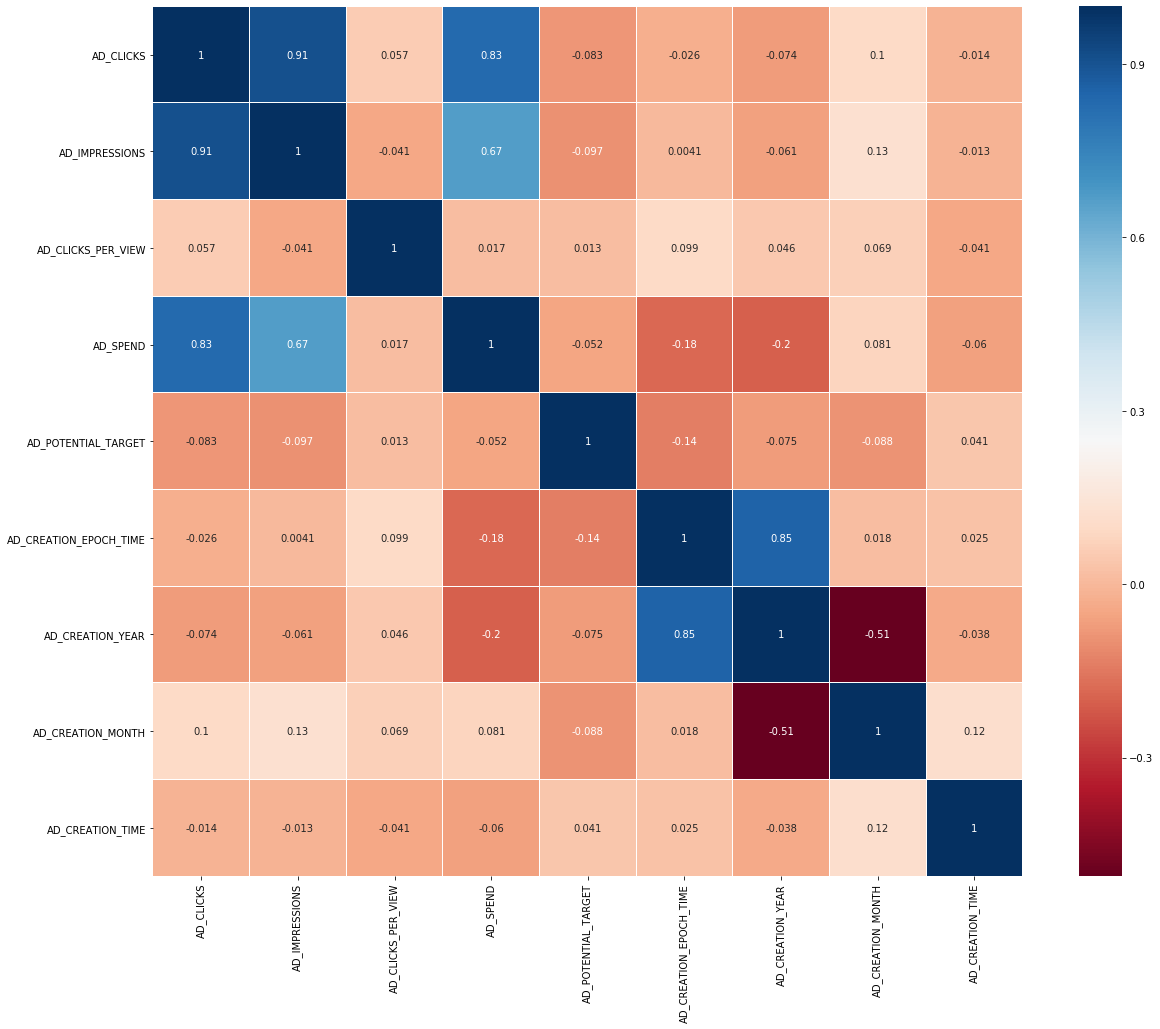

In [36]:
ax=plt.figure(figsize=(20,16)).gca()
sns.heatmap(dCorr,ax=ax,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);
plt.savefig(r"../Images/corrDuplicate.png")

In [37]:
corrDuplicateDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_CREATION_WEEKDAY']].corr(method='spearman')

,AD_CLICKS,AD_IMPRESSIONS,AD_CLICKS_PER_VIEW,AD_CREATION_WEEKDAY
AD_CLICKS,1.000000,0.924228,0.505427,0.105235
AD_IMPRESSIONS,0.924228,1.000000,0.215173,0.134442
AD_CLICKS_PER_VIEW,0.505427,0.215173,1.000000,-0.041521
AD_CREATION_WEEKDAY,0.105235,0.134442,-0.041521,1.000000


### Regression Model
**[TODO]** ==> Julian

In [38]:
X= corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME', 'AD_POTENTIAL_TARGET', 'AD_SPEND']]
#X= corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_MONTH', 'AD_CREATION_YEAR', 'AD_POTENTIAL_TARGET', 'AD_SPEND', 'AD_CREATION_TIME']]
Y= corrDf['AD_CLICKS_PER_VIEW']

In [39]:
sc = StandardScaler()
X_std = sc.fit_transform(X)

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=0)

#### Normal Multiple Linear Regression

In [41]:
reg = LinearRegression()
reg.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
y_pred = reg.predict(X_test)

In [43]:
print(reg.coef_)

[ 2.71650853e-03  8.36448301e-12 -2.24509755e-01 -1.91774315e-02
  1.97977694e-07  1.85123338e-11 -1.92447989e-06]


In [44]:
print(reg.intercept_)

440.5510623861301


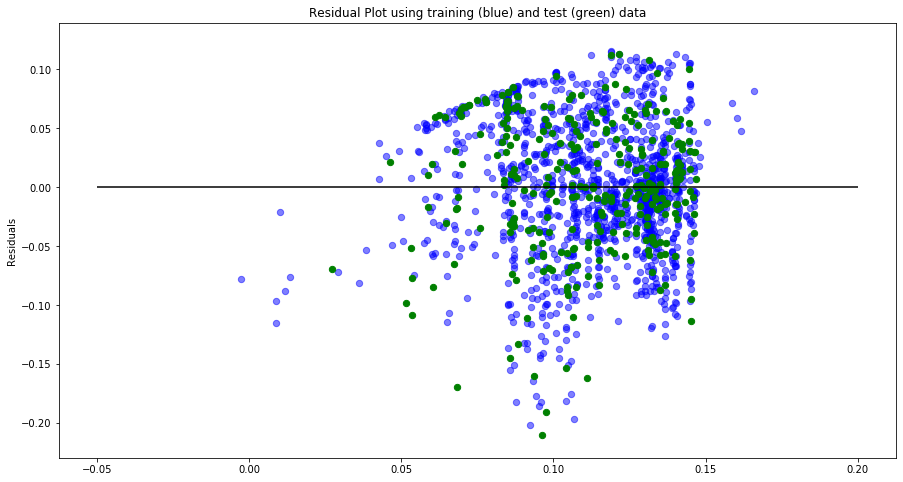

In [45]:
plt.scatter(reg.predict(X_train), reg.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(reg.predict(X_test), reg.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y=0, xmin=-0.05, xmax=0.2)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

**Very low R^2 score, so the prediction isn't very good**

In [46]:
r2_score(Y_test, y_pred)

0.15606168886315275

In [47]:
reg.score(X_test,Y_test)

0.15606168886315275

In [48]:
mean_squared_error(Y_test, y_pred)

0.0031560733890617964

#### Multiple Linear Regression (Lasso)

In [49]:
regLasso = Lasso()
regLasso.fit(X_train, Y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [50]:
y_pred_lasso = regLasso.predict(X_test)

In [51]:
print(regLasso.coef_)

[ 0.00000000e+00  1.35423820e-12  0.00000000e+00 -0.00000000e+00
  1.56191408e-07  4.43945815e-11 -1.88378646e-06]


In [52]:
print(regLasso.intercept_)

-1.8931169392466198


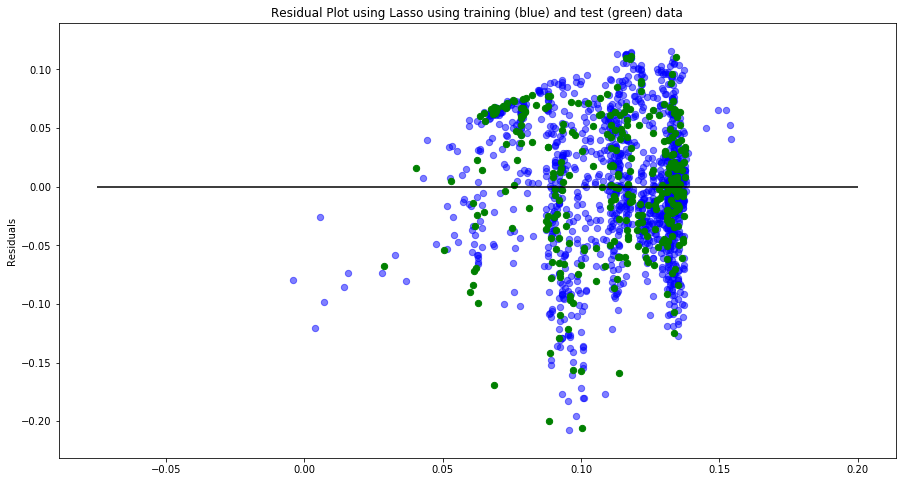

In [53]:
plt.scatter(regLasso.predict(X_train), regLasso.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(regLasso.predict(X_test), regLasso.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y=0, xmin=-0.075, xmax=0.2)
plt.title('Residual Plot using Lasso using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

**Also a very low R^2 score, so the prediction isn't very good**

In [54]:
r2_score(Y_test, y_pred_lasso)

0.1471498523616549

In [55]:
regLasso.score(X_test,Y_test)

0.1471498523616549

In [56]:
mean_squared_error(Y_test, y_pred_lasso)

0.003189400955376636

#### Multiple Linear Regression (Ridge)

In [57]:
regRidge = Ridge()
regRidge.fit(X_train, Y_train)

/anaconda3/envs/css/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.94864e-24): result may not be accurate.
  overwrite_a=True).T


Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [58]:
y_pred_ridge = regRidge.predict(X_test)

In [59]:
print(regRidge.coef_)

[ 2.81866824e-03  3.66854366e-12 -7.53713782e-02 -6.87284661e-03
  1.96517075e-07  1.77767531e-11 -1.92031550e-06]


In [60]:
print(regRidge.intercept_)

146.69790356373232


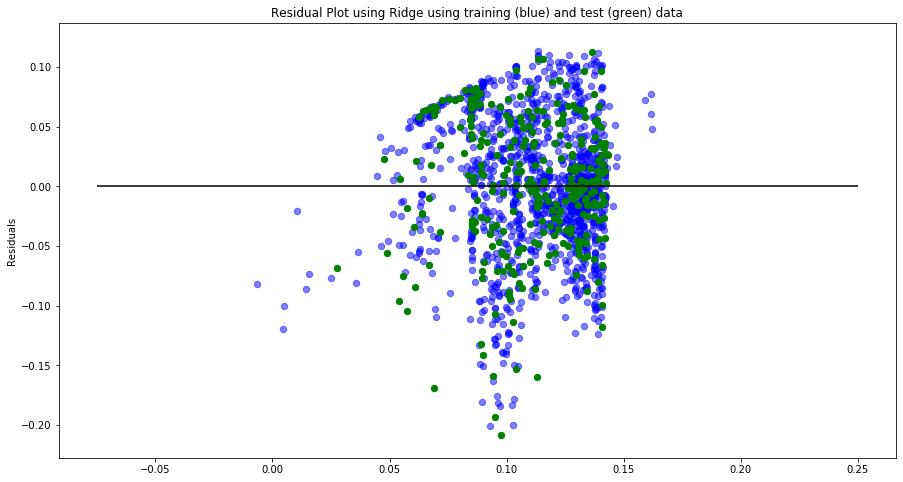

In [61]:
plt.scatter(regRidge.predict(X_train), regRidge.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(regRidge.predict(X_test), regRidge.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y=0, xmin=-0.075, xmax=0.25)
plt.title('Residual Plot using Ridge using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

In [62]:
r2_score(Y_test, y_pred_ridge)

0.15100930039314275

In [63]:
regRidge.score(X_test, Y_test)

0.15100930039314275

In [64]:
mean_squared_error(Y_test, y_pred_ridge)

0.003174967789980652

#### Multiple Linear Regression (Elastic Net)

In [65]:
regElastic = ElasticNet(normalize=True)
search=GridSearchCV(estimator=regElastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)

search.fit(X,Y)
param = search.best_params_

In [66]:
regElastic=ElasticNet(normalize=True,alpha=param['alpha'],l1_ratio=param['l1_ratio'])
regElastic.fit(X_train, Y_train)

ElasticNet(alpha=0.0001, copy_X=True, fit_intercept=True, l1_ratio=0.4,
           max_iter=1000, normalize=True, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [67]:
y_pred_elastic = regElastic.predict(X_test)

In [68]:
print(regElastic.coef_)

[ 1.79538869e-03  8.76901928e-13  9.01437835e-03 -0.00000000e+00
  1.05357919e-07  0.00000000e+00 -1.54494228e-06]


In [69]:
print(regElastic.intercept_)

-19.36641908279662


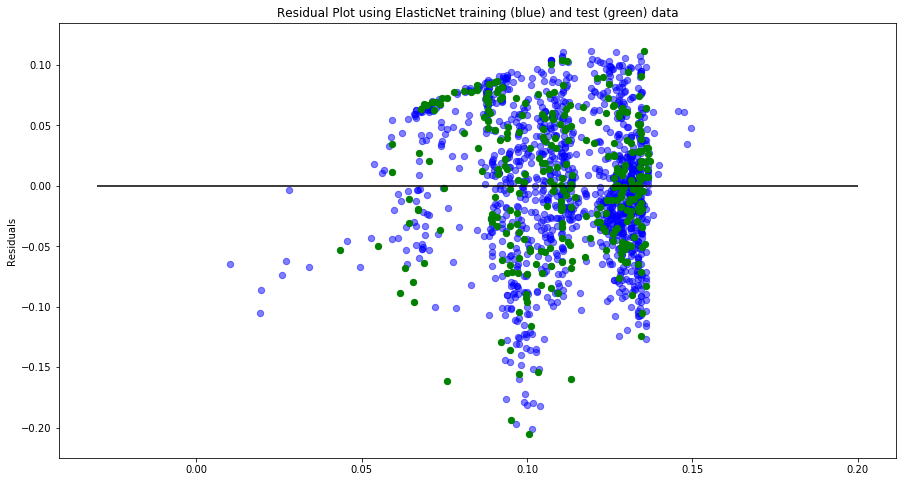

In [70]:
plt.scatter(regElastic.predict(X_train), regElastic.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(regElastic.predict(X_test), regElastic.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y=0, xmin=-0.03, xmax=0.2)
plt.title('Residual Plot using ElasticNet training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

In [71]:
r2_score(Y_test, y_pred_elastic)

0.140299464473864

In [72]:
regElastic.score(X_test, Y_test)

0.140299464473864

In [73]:
mean_squared_error(Y_test, y_pred_elastic)

0.00321501932893795

### Polynomial Regression

In [74]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_std)
X_train, X_test, Y_train, Y_test = train_test_split(X_poly,Y, test_size=0.2, random_state=0)

In [75]:
#X= corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_MONTH', 'AD_CREATION_YEAR', 'AD_POTENTIAL_TARGET', 'AD_SPEND', 'AD_CREATION_TIME']]
#Y= corrDf['AD_CLICKS_PER_VIEW']

#model = sm.OLS(Y, X).fit()
#predictions = model.predict(X)

#model.summary()

#### Polynomial Regression

In [76]:
    pr = LinearRegression()
    pr.fit(X_train, Y_train)
    Y_train_pred = pr.predict(X_train)
    Y_test_pred = pr.predict(X_test)

    print('R-Squared train: %.2f, test: %.2f' % (r2_score(Y_train, Y_train_pred), r2_score(Y_test, Y_test_pred)))
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(Y_train, Y_train_pred),
                    mean_squared_error(Y_test, Y_test_pred))) 

R-Squared train: 0.31, test: 0.27
MSE train: 0.00, test: 0.00


#### Polynomial Regression (Ridge)

In [77]:
for i in [0, 1, 10, 100, 1000]:
    pr_ridge = Ridge(alpha=i)
    pr_ridge.fit(X_train, Y_train)
    Y_train_pred = pr_ridge.predict(X_train)
    Y_test_pred = pr_ridge.predict(X_test)

    print('\n[Alpha = %d]' % i )
    print('R-Squared train: %.2f, test: %.2f' % (r2_score(Y_train, Y_train_pred), r2_score(Y_test, Y_test_pred)))
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(Y_train, Y_train_pred),
                    mean_squared_error(Y_test, Y_test_pred))) 


[Alpha = 0]
R-Squared train: 0.31, test: 0.27
MSE train: 0.00, test: 0.00

[Alpha = 1]
R-Squared train: 0.31, test: 0.26
MSE train: 0.00, test: 0.00

[Alpha = 10]
R-Squared train: 0.31, test: 0.26
MSE train: 0.00, test: 0.00

[Alpha = 100]
R-Squared train: 0.30, test: 0.26
MSE train: 0.00, test: 0.00

[Alpha = 1000]
R-Squared train: 0.24, test: 0.22
MSE train: 0.00, test: 0.00


#### Polynomial Regression (Lasso)

In [78]:
for i in [0.01, 1, 10, 100, 1000]:
    pr_lasso = Lasso(alpha=i, tol=0.01)
    pr_lasso.fit(X_train, Y_train)
    Y_train_pred = pr_lasso.predict(X_train)
    Y_test_pred = pr_lasso.predict(X_test)

    print('\n[Alpha = %d]' % i )
    print('R-Squared train: %.2f, test: %.2f' % (r2_score(Y_train, Y_train_pred), r2_score(Y_test, Y_test_pred)))
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(Y_train, Y_train_pred),
                    mean_squared_error(Y_test, Y_test_pred))) 


[Alpha = 0]
R-Squared train: 0.16, test: 0.15
MSE train: 0.00, test: 0.00

[Alpha = 1]
R-Squared train: 0.00, test: -0.00
MSE train: 0.00, test: 0.00

[Alpha = 10]
R-Squared train: 0.00, test: -0.00
MSE train: 0.00, test: 0.00

[Alpha = 100]
R-Squared train: 0.00, test: -0.00
MSE train: 0.00, test: 0.00

[Alpha = 1000]
R-Squared train: 0.00, test: -0.00
MSE train: 0.00, test: 0.00


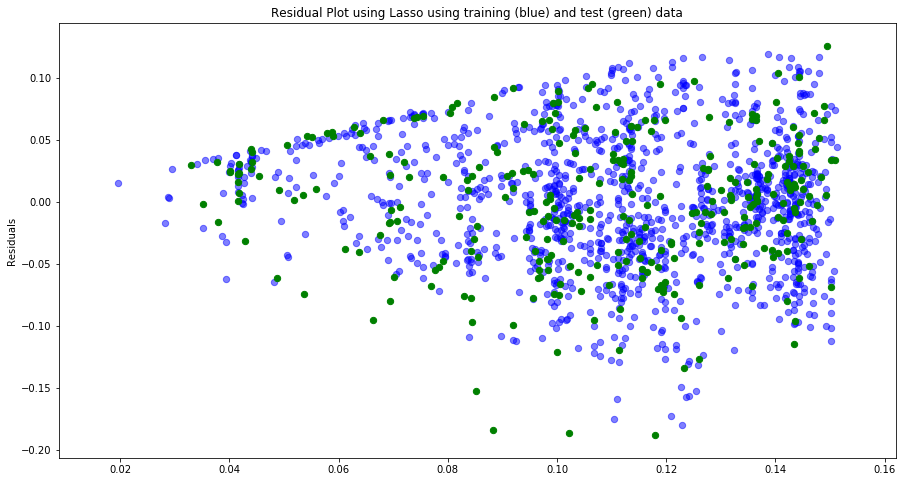

In [79]:
pr_lasso = Lasso(alpha=0.002, tol=0.2)
pr_lasso.fit(X_train, Y_train)
plt.scatter(pr_lasso.predict(X_train), pr_lasso.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(pr_lasso.predict(X_test), pr_lasso.predict(X_test) - Y_test, c='g', s=40)
plt.title('Residual Plot using Lasso using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

#### Polynomial Regression (ElasticNet)

In [80]:
for i in [0.01, 0.005, 1, 10, 100, 1000]:
    pr_elastic = ElasticNet(alpha=i, tol=0.2)
    pr_elastic.fit(X_train, Y_train)
    Y_train_pred = pr_elastic.predict(X_train)
    Y_test_pred = pr_elastic.predict(X_test)

    print('\n[Alpha = %d]' % i )
    print('R-Squared train: %.2f, test: %.2f' % (r2_score(Y_train, Y_train_pred), r2_score(Y_test, Y_test_pred)))
    print('MSE train: %.2f, test: %.2f' % (
                    mean_squared_error(Y_train, Y_train_pred),
                    mean_squared_error(Y_test, Y_test_pred)))


[Alpha = 0]
R-Squared train: 0.21, test: 0.20
MSE train: 0.00, test: 0.00

[Alpha = 0]
R-Squared train: 0.26, test: 0.24
MSE train: 0.00, test: 0.00

[Alpha = 1]
R-Squared train: 0.00, test: -0.00
MSE train: 0.00, test: 0.00

[Alpha = 10]
R-Squared train: 0.00, test: -0.00
MSE train: 0.00, test: 0.00

[Alpha = 100]
R-Squared train: 0.00, test: -0.00
MSE train: 0.00, test: 0.00

[Alpha = 1000]
R-Squared train: 0.00, test: -0.00
MSE train: 0.00, test: 0.00


In [81]:
pr_elastic = ElasticNet(normalize=True)
search=GridSearchCV(estimator=pr_elastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)
search.fit(X,Y)
param = search.best_params_
pr_elastic=ElasticNet(normalize=True,alpha=param['alpha'],l1_ratio=param['l1_ratio'])
pr_elastic.fit(X_train, Y_train)
Y_train_pred = pr_elastic.predict(X_train)
Y_test_pred = pr_elastic.predict(X_test)

In [82]:
print('R-Squared train: %.2f, test: %.2f' % (r2_score(Y_train, Y_train_pred), r2_score(Y_test, Y_test_pred)))

R-Squared train: 0.27, test: 0.25


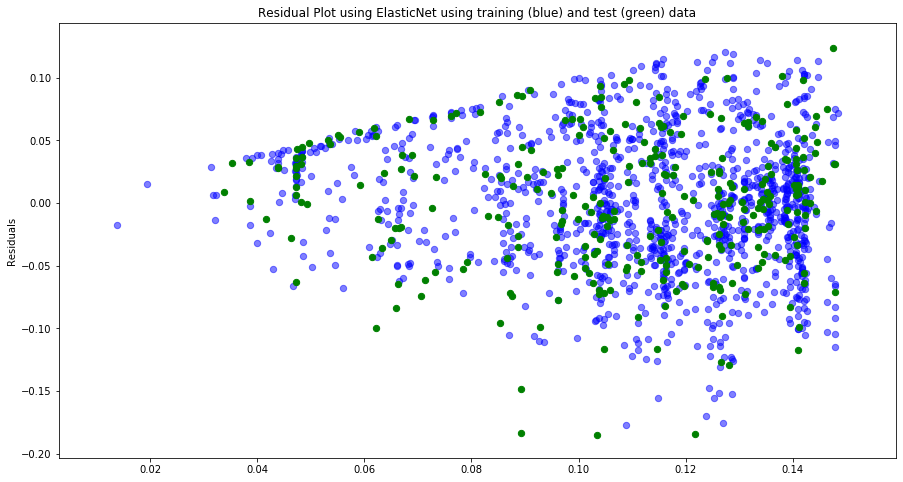

In [83]:
plt.scatter(pr_elastic.predict(X_train), pr_elastic.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(pr_elastic.predict(X_test), pr_elastic.predict(X_test) - Y_test, c='g', s=40)
plt.title('Residual Plot using ElasticNet using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

------------

In [84]:
def regression(X, Y):
    for x_el in X:
        #sc = RobustScaler()
        #x_el = sc.fit_transform(x_el)
        X_train, X_test, Y_train, Y_test = train_test_split(x_el,Y, test_size=0.2, random_state=0)

        print('Linear Regression:')
        #reg(x_el, X_train, X_test, Y_train, Y_test, LinearRegression())
        
        print('Linear Regression w/ Lasso:')
        #reg(x_el, X_train, X_test, Y_train, Y_test, Lasso())
        
        print('Linear Regression w/ Ridge:')
        #reg(x_el, X_train, X_test, Y_train, Y_test, Ridge())
        
        print('Linear Regression w/ ElasticNet:')    
        regElastic(x_el, X_train, X_test, Y_train, Y_test)
        
        poly = PolynomialFeatures(degree=2)
        X_poly = poly.fit_transform(x_el)
        X_train, X_test, Y_train, Y_test = train_test_split(X_poly,Y, test_size=0.2, random_state=0)
        
        print('Polynomial Regression:')
        #reg(x_el, X_train, X_test, Y_train, Y_test, LinearRegression())
        
        print('Polynomial Regression w/ Lasso:')
        #reg(x_el, X_train, X_test, Y_train, Y_test, Lasso())
        
        print('Polynomial Regression w/ Ridge:')
        #reg(x_el, X_train, X_test, Y_train, Y_test, Ridge()) 
        
        print('Polynomial Regression w/ ElasticNet:')    
        regElastic(x_el, X_train, X_test, Y_train, Y_test)
        

In [97]:
@ignore_warnings(category=ConvergenceWarning)
def reg(x_el, X_train, X_test, Y_train, Y_test, reg):
    reg.fit(X_train, Y_train)
    y_pred = reg.predict(X_test)
    coef = reg.coef_
    intercept = reg.intercept_
    r2 = r2_score(Y_test, y_pred)
    MSA = mean_absolute_error(Y_test, y_pred) 
    MSE = mean_squared_error(Y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(Y_test, y_pred))
    ev = explained_variance_score(Y_test, y_pred)
    
    df = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred})
    df1 = df.head(25)
    
    df1.plot(kind='bar',figsize=(10,8))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()
    
    plt.scatter(reg.predict(X_train), reg.predict(X_train) - Y_train, c='b', s=40, alpha=0.5, label='Train Data')
    plt.scatter(reg.predict(X_test), reg.predict(X_test) - Y_test, c='g', s=40, label='Test Data')
    plt.hlines(y=0, xmin=-0.03, xmax=0.2)
    plt.title('Residual Plot of Polynomial Regression using ElasticNet')
    plt.ylabel('Residuals')
    plt.xlabel('Predicted Click-per-View Ratio')
    plt.legend()
    plt.show()
    
    coef_dict_baseline = {}
    for coef, feat in zip(reg.coef_,x_el.columns):
        coef_dict_baseline[feat] = coef
    coef_dict_baseline
    
    print('Intercept: %.2f, R-Squared: %.8f, MSA: %.8f, MSE: %.8f, RMSE: %.8f, EV: %.8f' %(intercept, r2, MSA, MSE, RMSE, ev))
    print(coef_dict_baseline)

In [86]:
@ignore_warnings(category=ConvergenceWarning)
def regElastic(x_el, X_train, X_test, Y_train, Y_test):
    regElastic = ElasticNet(normalize=True)
    search=GridSearchCV(estimator=regElastic,param_grid={'alpha':np.logspace(-5,2,8),'l1_ratio':[.2,.4,.6,.8]},scoring='neg_mean_squared_error',n_jobs=1,refit=True,cv=10)
    
    search.fit(X_train,Y_train)
    param = search.best_params_

    regElastic=ElasticNet(normalize=True,alpha=param['alpha'],l1_ratio=param['l1_ratio'])
    regElastic.fit(X_train, Y_train)
    y_pred_elastic = regElastic.predict(X_test)
    coef_elastic = regElastic.coef_
    intercept_elastic = regElastic.intercept_
    r2_elastic = r2_score(Y_test, y_pred_elastic)
    MSA_elastic = mean_absolute_error(Y_test, y_pred_elastic) 
    MSE_elastic = mean_squared_error(Y_test, y_pred_elastic)
    RMSE_elastic = np.sqrt(mean_squared_error(Y_test, y_pred_elastic))
    ev = explained_variance_score(Y_test, y_pred_elastic)
    
    df = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred_elastic})
    df1 = df.head(25)
    
    df1.plot(kind='bar',figsize=(10,8))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()
    
    plt.scatter(regElastic.predict(X_train), regElastic.predict(X_train) - Y_train, c='b', s=40, alpha=0.5, label='Train Data')
    plt.scatter(regElastic.predict(X_test), regElastic.predict(X_test) - Y_test, c='g', s=40, label='Test Data')
    plt.hlines(y=0, xmin=-0.03, xmax=0.2)
    plt.title('Residual Plot of Polynomial Regression using ElasticNet')
    plt.ylabel('Residuals')
    plt.xlabel('Predicted Click-per-View Ratio')
    plt.legend()
    plt.show()
    
    coef_dict_elastic = {}
    for coef, feat in zip(regElastic.coef_,x_el.columns):
        coef_dict_elastic[feat] = coef
    coef_dict_elastic
    print('Intercept: %.8f, R-Squared: %.8f, MSA: %.8f, MSE: %.8f, RMSE: %.8f, EV: %.8f' %(intercept_elastic, r2_elastic, MSA_elastic, MSE_elastic, RMSE_elastic, ev))
    print(coef_dict_elastic, '\n')

In [88]:
X= [corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME']],corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']],corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME', 'AD_POTENTIAL_TARGET', 'AD_SPEND']], corrDf[['AD_POTENTIAL_TARGET', 'AD_SPEND']]]
#X= [corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME', 'AD_POTENTIAL_TARGET', 'AD_SPEND']]]
Y= corrDf['AD_CLICKS_PER_VIEW']

Linear Regression:
Linear Regression w/ Lasso:
Linear Regression w/ Ridge:
Linear Regression w/ ElasticNet:
Intercept: -1.99881721, R-Squared: 0.13014310, MSA: 0.04568258, MSE: 0.00325300, RMSE: 0.05703509, EV: 0.13041882
{'AD_CREATION_WEEKDAY': 0.002872486905116329, 'AD_CREATION_EPOCH_TIME': 1.4226290625346073e-12} 

Polynomial Regression:
Polynomial Regression w/ Lasso:
Polynomial Regression w/ Ridge:
Polynomial Regression w/ ElasticNet:
Intercept: -1.37114951, R-Squared: 0.12995238, MSA: 0.04573678, MSE: 0.00325371, RMSE: 0.05704134, EV: 0.13030246
{'AD_CREATION_WEEKDAY': 0.0, 'AD_CREATION_EPOCH_TIME': 0.0010118770733065546} 

Linear Regression:
Linear Regression w/ Lasso:
Linear Regression w/ Ridge:
Linear Regression w/ ElasticNet:
Intercept: -1.91257714, R-Squared: 0.12657087, MSA: 0.04568901, MSE: 0.00326636, RMSE: 0.05715208, EV: 0.12685822
{'AD_CREATION_WEEKDAY': 0.0028317507866216793, 'AD_CREATION_EPOCH_TIME': 1.364524475813287e-12, 'AD_CREATION_YEAR': 0.0, 'AD_CREATION_MONTH'

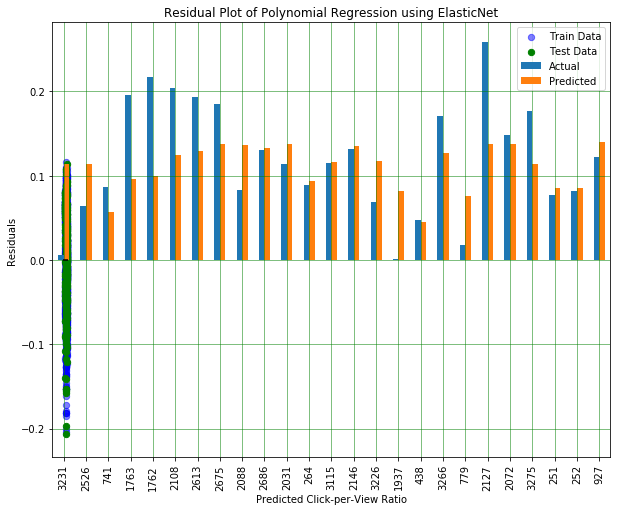

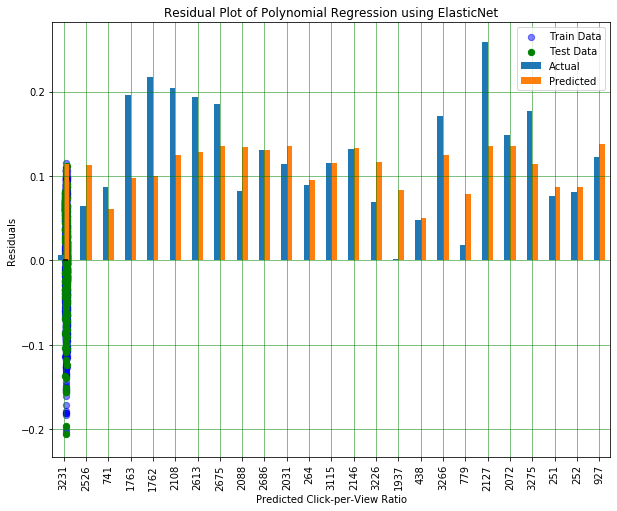

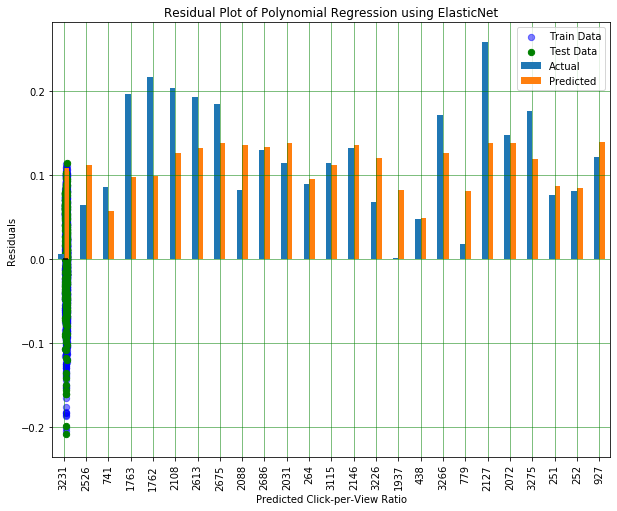

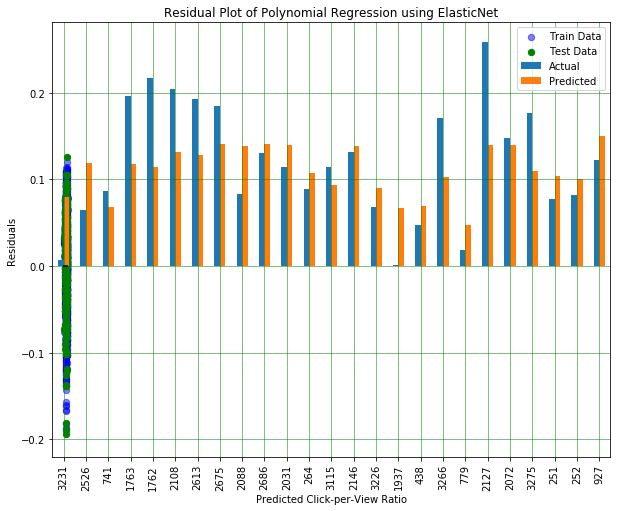

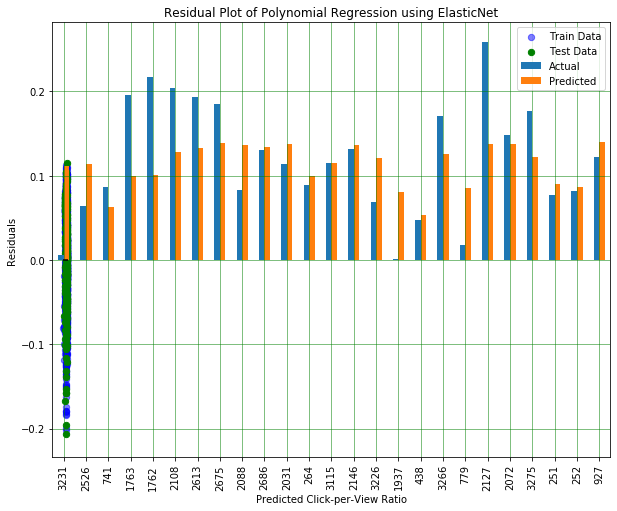

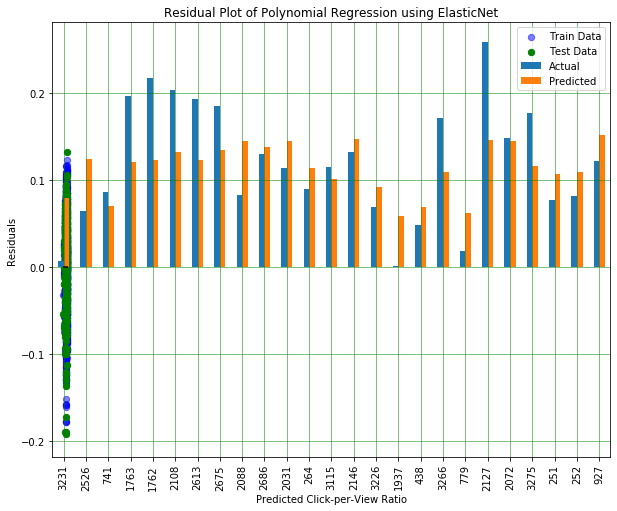

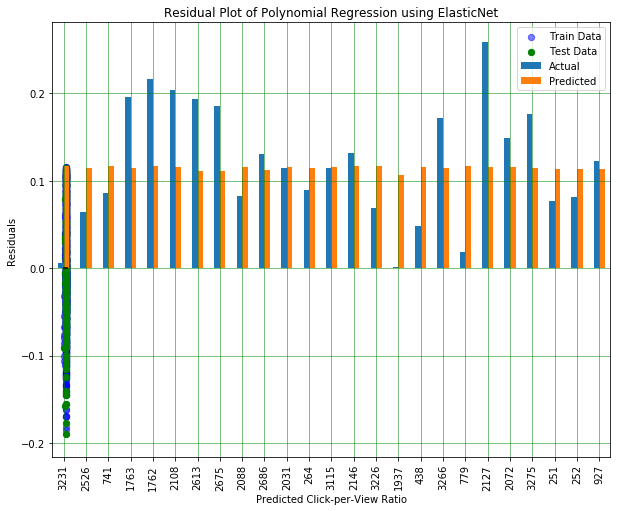

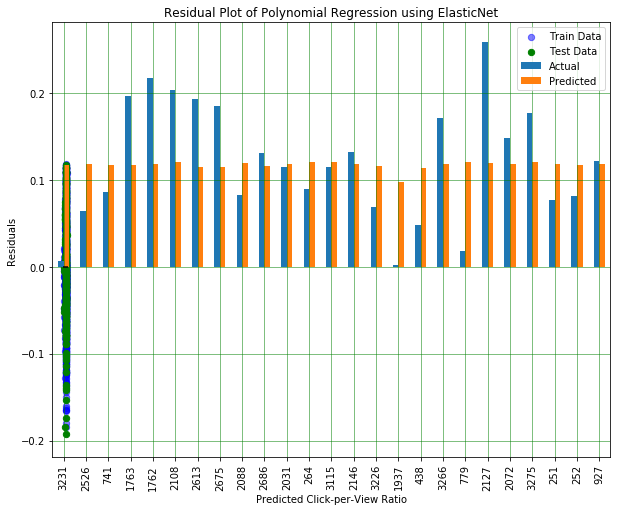

In [89]:
regression(X,Y)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395 entries, 2 to 3498
Data columns (total 11 columns):
AD_CLICKS                 395 non-null float64
AD_IMPRESSIONS            395 non-null float64
AD_CLICKS_PER_VIEW        395 non-null float64
AD_SPEND                  395 non-null float64
AD_POTENTIAL_TARGET       395 non-null float64
AD_CREATION_WEEKDAY       395 non-null int64
AD_CREATION_EPOCH_TIME    395 non-null float64
AD_CREATION_DATE          395 non-null datetime64[ns]
AD_CREATION_YEAR          395 non-null int64
AD_CREATION_MONTH         395 non-null int64
AD_CREATION_TIME          395 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(3)
memory usage: 37.0 KB
None
Linear Regression:
Linear Regression w/ Lasso:
Linear Regression w/ Ridge:
Linear Regression w/ ElasticNet:
Intercept: 99.92413399, R-Squared: 0.03944226, MSA: 0.04669507, MSE: 0.00310026, RMSE: 0.05568000, EV: 0.05467542
{'AD_CREATION_WEEKDAY': 0.0006620568806762833, 'AD_CREATION_EPOCH_TIME': 2.4492

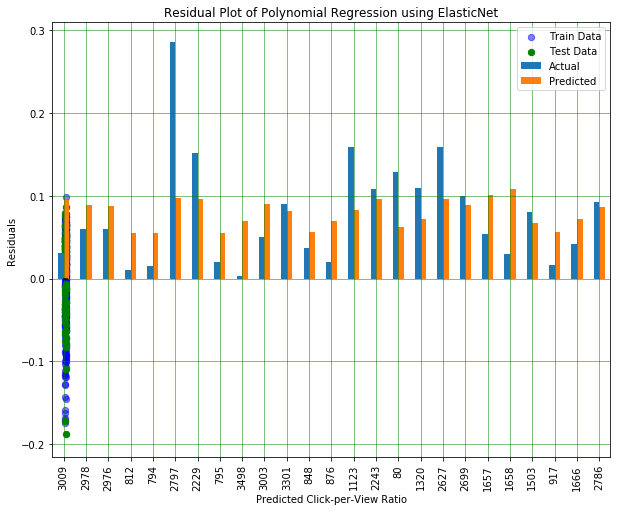

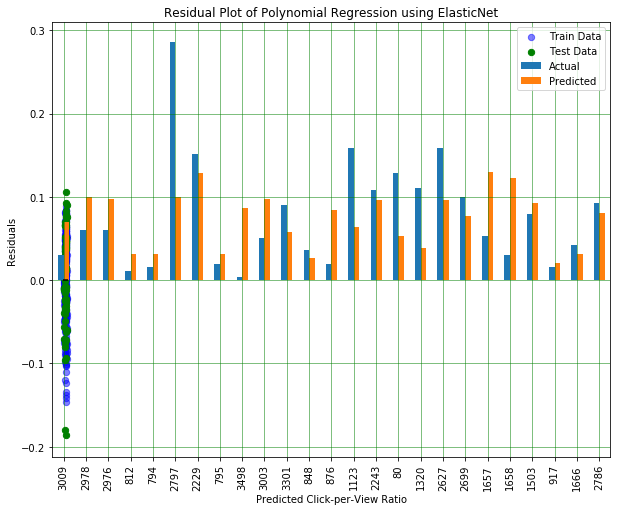

In [93]:
corrDf = ira_data[ira_data['Duplicate']==True][[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']].dropna()
std_dev = 3
corrDf = corrDf[(np.abs(stats.zscore(corrDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_SPEND']])) < float(std_dev)).all(axis=1)]
print(corrDf.info())
#X= [corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME']],corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']],corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME', 'AD_POTENTIAL_TARGET', 'AD_SPEND']], corrDf[['AD_POTENTIAL_TARGET', 'AD_SPEND']]]
X= [corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME', 'AD_POTENTIAL_TARGET', 'AD_SPEND']]]
Y= corrDf['AD_CLICKS_PER_VIEW']
regression(X,Y)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1182 entries, 1 to 3517
Data columns (total 11 columns):
AD_CLICKS                 1182 non-null float64
AD_IMPRESSIONS            1182 non-null float64
AD_CLICKS_PER_VIEW        1182 non-null float64
AD_SPEND                  1182 non-null float64
AD_POTENTIAL_TARGET       1182 non-null float64
AD_CREATION_WEEKDAY       1182 non-null int64
AD_CREATION_EPOCH_TIME    1182 non-null float64
AD_CREATION_DATE          1182 non-null datetime64[ns]
AD_CREATION_YEAR          1182 non-null int64
AD_CREATION_MONTH         1182 non-null int64
AD_CREATION_TIME          1182 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(3)
memory usage: 110.8 KB
None
Linear Regression:
Linear Regression w/ Lasso:
Linear Regression w/ Ridge:
Linear Regression w/ ElasticNet:
Intercept: -17.03960015, R-Squared: 0.14831062, MSA: 0.04679656, MSE: 0.00347733, RMSE: 0.05896887, EV: 0.14834434
{'AD_CREATION_WEEKDAY': 0.0041004369572397725, 'AD_CREATION_EPOCH

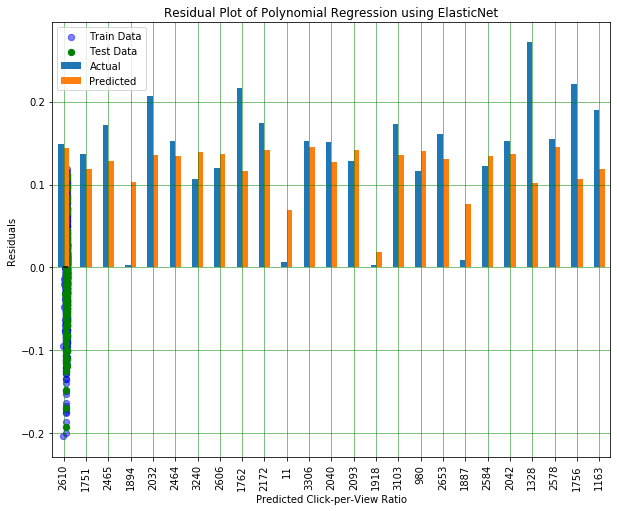

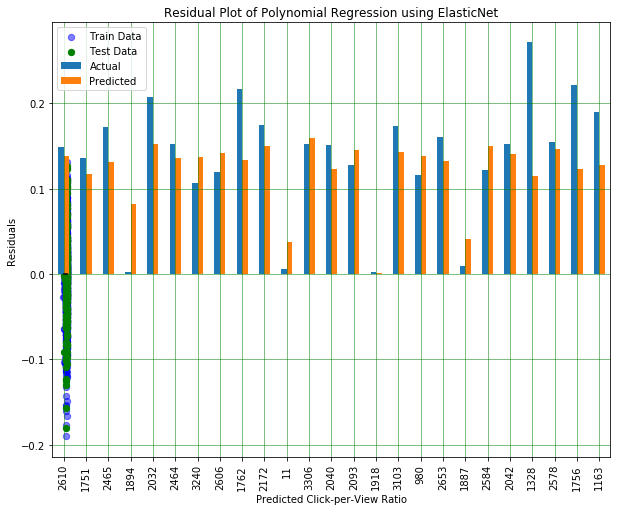

In [98]:
corrDf = ira_data[ira_data['Duplicate']==False][[ 'AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_SPEND', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_DATE', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']].dropna()
std_dev = 3
corrDf = corrDf[(np.abs(stats.zscore(corrDf[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_SPEND']])) < float(std_dev)).all(axis=1)]
print(corrDf.info())
#X= [corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME']],corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME']],corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME', 'AD_POTENTIAL_TARGET', 'AD_SPEND']], corrDf[['AD_POTENTIAL_TARGET', 'AD_SPEND']]]
X= [corrDf[['AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME', 'AD_POTENTIAL_TARGET', 'AD_SPEND']]]
Y= corrDf['AD_CLICKS_PER_VIEW']
regression(X,Y)

------

In [99]:
df = ira_data[(ira_data['Duplicate'] == True) & ira_data['AD_TEXT'].str.match('We speak for all fellow members of LGBT community across the nation.')][['AD_CLICKS', 'AD_CLICKS_PER_VIEW', 'AD_IMPRESSIONS', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_TIME', 'AD_SPEND', 'AD_POTENTIAL_TARGET']].dropna()
X= df[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_CREATION_TIME', 'AD_SPEND', 'AD_POTENTIAL_TARGET']]
Y= df['AD_CLICKS_PER_VIEW']

R-Squared: 0.766084060028923
MSE: 0.01184420117129832


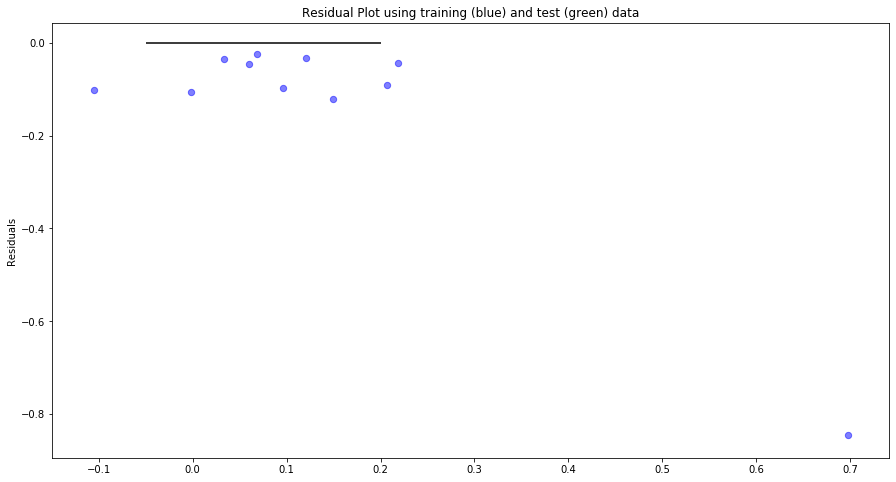

In [100]:
reg = LinearRegression()
reg.fit(X, Y)
y_pred = reg.predict(X)
print('R-Squared:',r2_score(Y, y_pred))
print('MSE:',mean_squared_error(Y, y_pred))
plt.scatter(y_pred,  - Y, c='b', s=40, alpha=0.5)
plt.hlines(y=0, xmin=-0.05, xmax=0.2)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')
plt.show()

---------

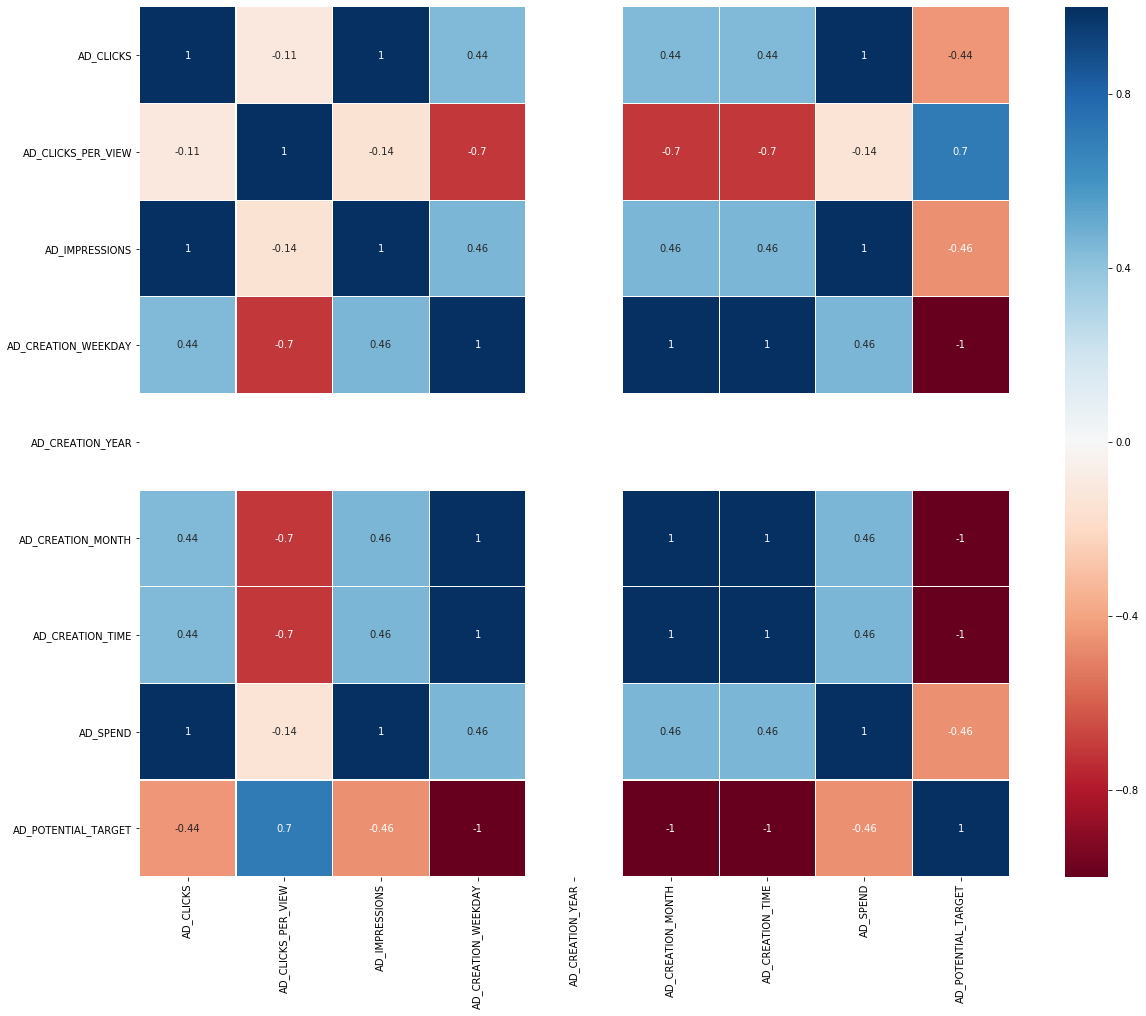

Fast-growing black community. Latest news and everyday updates! :  6


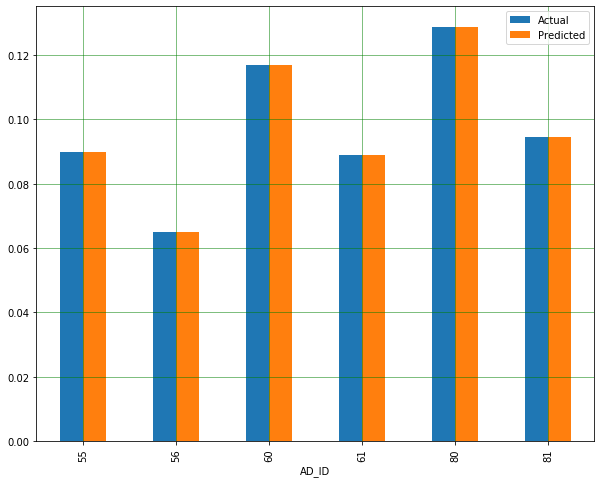

{'AD_CLICKS': 0.0014911708957492515, 'AD_IMPRESSIONS': -6.984118714093225e-05, 'AD_CREATION_WEEKDAY': -8.379937182543864e-10, 'AD_CREATION_YEAR': 1.638773752116185e-13, 'AD_CREATION_MONTH': -4.190793997318729e-10, 'AD_CREATION_TIME': 0.28109466066644456, 'AD_SPEND': -0.0002120713140608001, 'AD_POTENTIAL_TARGET': 0.002514477225975733}
R-Squared: 1.0
MSE: 2.4971845117548755e-23


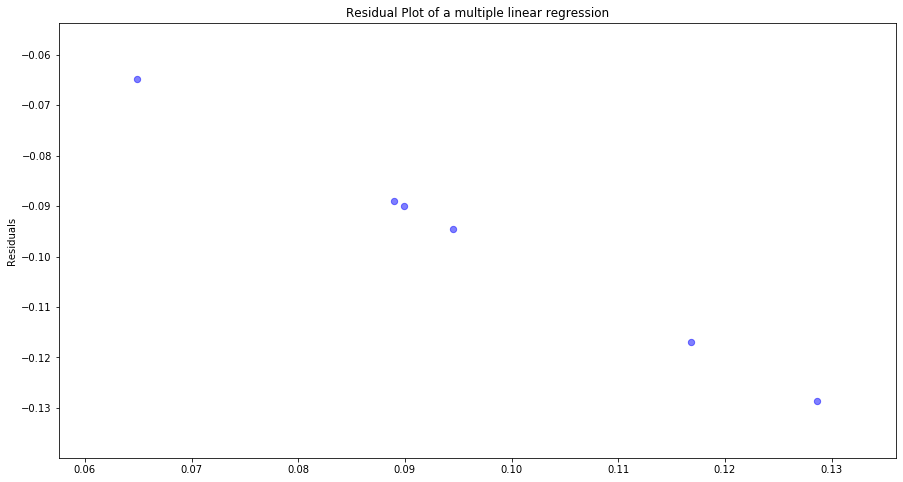

KeyError: 'AD_TEXT'

In [107]:
df = ira_data[((ira_data['Duplicate'] == True) & ira_data['AD_IMPRESSIONS']>0) & ira_data['AD_CLICKS']>0][['AD_TEXT','AD_CLICKS', 'AD_CLICKS_PER_VIEW', 'AD_IMPRESSIONS', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_TIME', 'AD_CREATION_EPOCH_TIME', 'AD_SPEND', 'AD_POTENTIAL_TARGET']].dropna()
std_dev = 3
df = df[(np.abs(stats.zscore(df[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CLICKS_PER_VIEW', 'AD_POTENTIAL_TARGET','AD_CREATION_WEEKDAY', 'AD_CREATION_EPOCH_TIME', 'AD_CREATION_YEAR', 'AD_CREATION_MONTH', 'AD_SPEND']])) < float(std_dev)).all(axis=1)]

unique = df.groupby("AD_TEXT").filter(lambda x: len(x) >= 5)['AD_TEXT'].unique()

i = 0
for x in unique:
    df_new = df[df['AD_TEXT'].str.match(x)][['AD_CLICKS', 'AD_CLICKS_PER_VIEW', 'AD_IMPRESSIONS', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_TIME', 'AD_SPEND', 'AD_POTENTIAL_TARGET']].dropna()
    X= df_new[['AD_CLICKS', 'AD_IMPRESSIONS', 'AD_CREATION_WEEKDAY','AD_CREATION_YEAR', 'AD_CREATION_MONTH','AD_CREATION_TIME', 'AD_SPEND', 'AD_POTENTIAL_TARGET']]
    Y= df_new['AD_CLICKS_PER_VIEW']  
    
    ax=plt.figure(figsize=(20,16)).gca()
    sns.heatmap(df_new.corr(),ax=ax,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True);
    
    location = ''.join(['../Images/corrDuplicates_', str(i), '.png'])
    plt.savefig(r"%s" % str(location));
    plt.show()
    
    print(x, ': ', df[df['AD_TEXT'].str.match(x)]['AD_TEXT'].count())
    reg = LinearRegression()
    reg.fit(X, Y)
    y_pred = reg.predict(X)
    
    df = pd.DataFrame({'Actual': Y, 'Predicted': y_pred})
    df1 = df.head(25)
    
    df1.plot(kind='bar',figsize=(10,8))
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    plt.show()
    
    coef_dict_elastic = {}
    for coef, feat in zip(reg.coef_,X.columns):
        coef_dict_elastic[feat] = coef
    coef_dict_elastic
    print(coef_dict_elastic)
    print('R-Squared:',r2_score(Y, y_pred))
    print('MSE:',mean_squared_error(Y, y_pred))
    plt.scatter(y_pred,  - Y, c='b', s=40, alpha=0.5)
    plt.title('Residual Plot of a multiple linear regression')
    plt.ylabel('Residuals')
    location = ''.join(['../Images/residualGraphDuplicates_', str(i), '.png'])
    plt.savefig(r"%s" % str(location));
    plt.show()
    i=i+1

------

In [ ]:
regression=LinearRegression()
regression.fit(X,Y)
first_model=(mean_squared_error(y_true=Y,y_pred=regression.predict(X)))
print(first_model)

In [ ]:
coef_dict_baseline = {}
for coef, feat in zip(regression.coef_,X.columns):
    coef_dict_baseline[feat] = coef
coef_dict_baseline

### ElasticNet Regression

In [ ]:
sns.regplot(x="AD_POTENTIAL_TARGET", y="AD_CLICKS_PER_VIEW", data=corrDf);

### Polynomial Regression

In [ ]:
def pol_regression(X, Y):
    transformer = PolynomialFeatures(degree=2, include_bias=True)
    transformer.fit(X)
    X_ = transformer.transform(X)
    model = LinearRegression()
    model.fit(X_, Y)
    intercept, coefficients = model.intercept_, model.coef_
    r_sq = model.score(X_, Y)
    y_pred = model.predict(X_)
    return dict([('intercept', intercept), ('coefficients', coefficients), ('r_sq', r_sq), ('pred', y_pred)])

In [ ]:
print(pol_regression(X, Y))

In [ ]:
sns.distplot(corrDf['AD_CLICKS_PER_VIEW'].dropna());

In [ ]:
print(ira_data.AD_CLICKS_PER_VIEW.describe())
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(ira_data.AD_CLICKS_PER_VIEW.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(ira_data.AD_CLICKS_PER_VIEW.dropna(), plot=plt)

In [ ]:
cpv = ira_data.AD_CLICKS_PER_VIEW
ira_data.AD_CLICKS_PER_VIEW = np.log(cpv)

In [ ]:
print(ira_data.AD_CLICKS_PER_VIEW.describe())
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.distplot(ira_data.AD_CLICKS_PER_VIEW.dropna() , fit=stats.norm);
plt.subplot(1,2,2)
_=stats.probplot(ira_data.AD_CLICKS_PER_VIEW.dropna(), plot=plt)